In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.4.1


In [3]:
meta_info_path = 'data'
pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90.csv')
pose_index.head()

,level1_id,level1_pose,level2_id,level2_pose,l3_pose_id,13_pose
0,1,standing,11,standing-straight,101,mountain
1,1,standing,11,standing-straight,102,goddess
2,1,standing,11,standing-straight,103,eagle
3,1,standing,11,standing-straight,104,tree
4,1,standing,11,standing-straight,105,chair


In [4]:
# Peek the structure of the csv
sequence_index.head()

,sequence_id,url_id,url,frame_start,frame_end,sequence_duration,source_id,source,l1_pose_id,l1_pose,l2_pose_id,l2_pose,l3_pose_id,l3_pose,collector_id,split
0,1000,1530,https://www.youtube.com/watch?v=5vIJX7SIiJo,159,163,4,1089,Alo Yoga,1,standing,11,standing-straight,101,mountain,3,train
1,1002,2943,https://www.youtube.com/watch?v=HelFdy8B4X4,46,49,3,1168,Ashtanga Nurse,1,standing,11,standing-straight,101,mountain,3,train
2,1003,3277,https://www.youtube.com/watch?v=jMJfl5w30Ds,1859,1861,2,1247,Bharti Yoga,1,standing,11,standing-straight,101,mountain,3,test
3,1004,1904,https://www.youtube.com/watch?v=AoGt1DKsiDo,747,749,2,1308,Cat Meffan,1,standing,11,standing-straight,101,mountain,3,train
4,1005,4630,https://www.youtube.com/watch?v=syXsoVb8NVo,48,52,4,1369,COSMIN YOGI,1,standing,11,standing-straight,101,mountain,3,train


In [5]:
pd.read_parquet(r"official_dataset\3100.parquet")

,frame,row_id,type,landmark_index,x,y,z
0,0,0-pose-0,pose,0,-0.126601,-0.648421,-0.122946
1,0,0-pose-1,pose,1,-0.113704,-0.671741,-0.142793
2,0,0-pose-2,pose,2,-0.113255,-0.672233,-0.142134
3,0,0-pose-3,pose,3,-0.113002,-0.672770,-0.143131
4,0,0-pose-4,pose,4,-0.111807,-0.675319,-0.109025
...,...,...,...,...,...,...,...
41575,1259,1259-pose-28,pose,28,0.145928,0.819348,0.197815
41576,1259,1259-pose-29,pose,29,0.049040,-0.908933,0.089477
41577,1259,1259-pose-30,pose,30,0.144581,0.863024,0.193803
41578,1259,1259-pose-31,pose,31,0.045163,-1.030170,0.070174


What does each file tell? 

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL, 
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [6]:
the_desired_poses = [
  'downward-dog',
  'high-lunge',
  'low-lunge',
  'warrior-3',
  'side-plank',
  'balancing-table',
  'child',
  'tree',
  'extended-triangle',
  'bridge']

In [7]:
# Keep only relevant columns
parquet_index = sequence_index[['sequence_id', 'l3_pose', 'split']]
parquet_index

,sequence_id,l3_pose,split
0,1000,mountain,train
1,1002,mountain,train
2,1003,mountain,test
3,1004,mountain,train
4,1005,mountain,train
...,...,...,...
5521,7195,firefly,train
5522,7197,firefly,train
5523,7198,firefly,train
5524,7200,firefly,train


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class Yoga3DDataset(Dataset):
    def __init__(self, parquet_index, root_dir, transform=None, max_frames=None):
        self.parquet_index = parquet_index
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        
        # Create a mapping of pose names to integer labels
        self.pose_to_label = {pose: idx for idx, pose in enumerate(parquet_index['pose_name'].unique())}
        
    def __len__(self):
        return len(self.parquet_index)
    
    def __getitem__(self, idx):
        fname, pose_name, _ = self.parquet_index.iloc[idx]
        
        # Read the parquet file
        path = f"{self.root_dir}/{fname}.parquet"
        df = pd.read_parquet(path)
        df = df.drop(columns=['frame', 'row_id', 'type'])
        
        # Convert to tensor
        data = self.to_tensor(df)
        
        # Handle variable number of frames
        if self.max_frames:
            data = self.pad_or_truncate(data, self.max_frames)
        
        # Get the label
        label = self.pose_to_label[pose_name]
        
        if self.transform:
            data = self.transform(data)
        
        return data, label
    
    def to_tensor(self, df):
        # Reshape the data to (num_frames, num_landmarks, 3)
        num_frames = len(df) // 33  # Assuming 33 landmarks per frame
        data = df.values.reshape(num_frames, 33, 3)
        return torch.FloatTensor(data).permute(2, 0, 1)  # (3, num_frames, 33)
    
    def pad_or_truncate(self, tensor, target_frames):
        c, t, v = tensor.shape
        if t < target_frames:
            # Pad
            padding = torch.zeros(c, target_frames - t, v)
            return torch.cat([tensor, padding], dim=1)
        elif t > target_frames:
            # Truncate
            return tensor[:, :target_frames, :]
        else:
            return tensor

def create_data_loaders(parquet_index, root_dir, batch_size=32, max_frames=64, test_size=0.2, val_size=0.1):
    # Split the data into train, validation, and test sets
    train_val_index, test_index = train_test_split(parquet_index, test_size=test_size, stratify=parquet_index['pose_name'])
    train_index, val_index = train_test_split(train_val_index, test_size=val_size / (1 - test_size), stratify=train_val_index['pose_name'])
    
    # Create datasets
    train_dataset = Yoga3DDataset(train_index, root_dir, max_frames=max_frames)
    val_dataset = Yoga3DDataset(val_index, root_dir, max_frames=max_frames)
    test_dataset = Yoga3DDataset(test_index, root_dir, max_frames=max_frames)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

# Example usage
parquet_index = pd.read_csv('path_to_your_parquet_index.csv')
root_dir = 'official_dataset'
train_loader, val_loader, test_loader = create_data_loaders(parquet_index, root_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_parquet_index.csv'

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class Yoga3DDataset(Dataset):
    def __init__(self, parquet_index, root_dir, transform=None, max_frames=None, one_hot=False):
        self.parquet_index = parquet_index
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        self.one_hot = one_hot
        
        # Create a mapping of pose names to integer labels
        unique_poses = parquet_index['pose_name'].unique()
        self.pose_to_label = {pose: idx for idx, pose in enumerate(unique_poses)}
        self.num_classes = len(unique_poses)
        
    def __len__(self):
        return len(self.parquet_index)
    
    def __getitem__(self, idx):
        fname, pose_name, _ = self.parquet_index.iloc[idx]
        
        # Read the parquet file
        path = f"{self.root_dir}/{fname}.parquet"
        df = pd.read_parquet(path)
        df = df.drop(columns=['frame', 'row_id', 'type'])
        
        # Convert to tensor
        data = self.to_tensor(df)
        
        # Handle variable number of frames
        if self.max_frames:
            data = self.pad_or_truncate(data, self.max_frames)
        
        # Get the label
        label = self.pose_to_label[pose_name]
        
        if self.one_hot:
            label = self.to_one_hot(label)
        
        if self.transform:
            data = self.transform(data)
        
        return data, label
    
    def to_tensor(self, df):
        # Reshape the data to (num_frames, num_landmarks, 3)
        num_frames = len(df) // 33  # Assuming 33 landmarks per frame
        data = df.values.reshape(num_frames, 33, 3)
        return torch.FloatTensor(data).permute(2, 0, 1)  # (3, num_frames, 33)
    
    def pad_or_truncate(self, tensor, target_frames):
        c, t, v = tensor.shape
        if t < target_frames:
            # Pad
            padding = torch.zeros(c, target_frames - t, v)
            return torch.cat([tensor, padding], dim=1)
        elif t > target_frames:
            # Truncate
            return tensor[:, :target_frames, :]
        else:
            return tensor
    
    def to_one_hot(self, label):
        one_hot = torch.zeros(self.num_classes)
        one_hot[label] = 1
        return one_hot

# Usage example
parquet_index = pd.read_csv('path_to_your_parquet_index.csv')
dataset = Yoga3DDataset(parquet_index, 'official_dataset', max_frames=64, one_hot=True)

In [ ]:
def to_tensor(df):
    return
def read_parquet_file(fname):
    fname = str(fname)
    path = 'official_dataset/' + fname + '.parquet'
    df = pd.read_parquet(path)
    df = df.drop(columns=['frame', 'row_id', 'type'])
    return df
max_frames = 0
min_frames = 0



for _, vals in parquet_index.iterrows():
    fname, pose_name, dtype = vals
    landmark_vals = read_parquet_file(fname)
    print(landmark_vals)
    # print(len(landmark_vals))
    break

      landmark_index         x         y         z
0                  0 -0.380631 -0.579215 -0.046176
1                  1 -0.360778 -0.601576 -0.066047
2                  2 -0.360961 -0.602298 -0.065145
3                  3 -0.361278 -0.602095 -0.065228
4                  4 -0.357422 -0.602949 -0.032138
...              ...       ...       ...       ...
3163              28  0.087418  0.791264  0.132929
3164              29  0.071910  0.829764 -0.041319
3165              30  0.080120  0.839086  0.132400
3166              31 -0.024822  0.848750 -0.109281
3167              32 -0.028863  0.856909  0.086600

[3168 rows x 4 columns]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AGCN(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes):
        super(AGCN, self).__init__()
        self.num_nodes = num_nodes
        self.A = nn.Parameter(torch.FloatTensor(num_nodes, num_nodes))
        nn.init.xavier_uniform_(self.A)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        # x shape: (batch_size, in_channels, num_frames, num_nodes)
        A = F.softmax(self.A, dim=1)
        D = torch.sum(A, dim=1).pow(-0.5)
        D = torch.diag(D)
        A_hat = torch.matmul(torch.matmul(D, A + torch.eye(self.num_nodes).to(A.device)), D)
        
        x = self.conv(x)  # Apply 1x1 conv
        output = torch.einsum('nctv,vw->nctw', (x, A_hat))
        return output
    
    def forward(self, x):
        x = self.conv(x)
        N, C, T, V = x.size()
        A = F.softmax(self.A, dim=1)
        x = torch.einsum('nctv,vw->nctw', (x, A))
        return x

class STSAM(nn.Module):
    def __init__(self, channels):
        super(STSAM, self).__init__()
        self.conv_q = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv_k = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv_v = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv_s = nn.Conv2d(channels, 1, kernel_size=1)
        self.conv_t = nn.Conv2d(channels, 1, kernel_size=1)
        
    def forward(self, x):
        # x shape: (batch_size, channels, num_frames, num_nodes)
        q, k, v = self.conv_q(x), self.conv_k(x), self.conv_v(x)
        
        # Spatial attention
        qs, ks, vs = q.mean(2, keepdim=True), k.mean(2, keepdim=True), v.mean(2, keepdim=True)
        attn_s = F.softmax(torch.matmul(qs.transpose(-2, -1), ks) / (qs.size(-1) ** 0.5), dim=-1)
        out_s = torch.matmul(vs, attn_s.transpose(-2, -1))
        out_s = self.conv_s(out_s)
        out_s = torch.sigmoid(out_s)
        
        # Temporal attention
        qt, kt, vt = q.mean(-1, keepdim=True), k.mean(-1, keepdim=True), v.mean(-1, keepdim=True)
        attn_t = F.softmax(torch.matmul(qt.transpose(-2, -1), kt) / (qt.size(-1) ** 0.5), dim=-1)
        out_t = torch.matmul(vt, attn_t.transpose(-2, -1))
        out_t = self.conv_t(out_t)
        out_t = torch.sigmoid(out_t)
        
        out = (x + x * out_s) + (x + x * out_t)
        return out

class MTCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MTCN, self).__init__()
        self.branch_channels = out_channels // 6
        self.conv_in = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.branch1 = nn.Conv2d(in_channels, self.branch_channels, kernel_size=1)
        self.branch2 = nn.MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0))
        self.branch3 = nn.Conv2d(in_channels, self.branch_channels, kernel_size=(3, 1), padding=(1, 0), dilation=1)
        self.branch4 = nn.Conv2d(in_channels, self.branch_channels, kernel_size=(3, 1), padding=(2, 0), dilation=2)
        self.branch5 = nn.Conv2d(in_channels, self.branch_channels, kernel_size=(3, 1), padding=(3, 0), dilation=3)
        self.branch6 = nn.Conv2d(in_channels, self.branch_channels, kernel_size=(3, 1), padding=(4, 0), dilation=4)
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.conv_in(x)
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        b5 = self.branch5(x)
        b6 = self.branch6(x)
        out = torch.cat([b1, b2, b3, b4, b5, b6], dim=1)
        out = self.conv_out(out)
        return out

class STSAE_GCN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes):
        super(STSAE_GCN_Block, self).__init__()
        self.agcn = AGCN(in_channels, out_channels, num_nodes)
        self.stsam = STSAM(out_channels)
        self.mtcn = MTCN(out_channels, out_channels)
        
    def forward(self, x):
        x = self.agcn(x)
        x = self.stsam(x)
        x = self.mtcn(x)
        return x

class STSAE_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, num_nodes, num_frames, num_blocks=9):
        super(STSAE_GCN, self).__init__()
        self.num_blocks = num_blocks
        
        self.blocks = nn.ModuleList([
            STSAE_GCN_Block(in_channels if i == 0 else hidden_channels, 
                            hidden_channels, 
                            num_nodes) 
            for i in range(num_blocks)
        ])
        
        self.fc = nn.Linear(hidden_channels * num_nodes * num_frames, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, in_channels, num_frames, num_nodes)
        for block in self.blocks:
            x = block(x)
        
        # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Example usage
in_channels = 3  # x, y, z coordinates from BlazePose
hidden_channels = 64
num_classes = 10  # Adjust based on your yoga action classes
num_nodes = 33  # BlazePose landmarks
num_frames = 64  # You may need to pad or sample your sequences to a fixed length
num_blocks = 9

model = STSAE_GCN(in_channels, hidden_channels, num_classes, num_nodes, num_frames, num_blocks)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_stsae_gcn(model, train_loader, val_loader, num_epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Example usage (you'll need to replace this with your actual data loading)
def load_data():
    # This is a placeholder. Replace with your actual data loading logic.
    num_samples = 1000
    num_frames = 64
    num_nodes = 33
    in_channels = 3
    num_classes = 10
    
    X = torch.randn(num_samples, in_channels, num_frames, num_nodes)
    y = torch.randint(0, num_classes, (num_samples,))
    
    dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader

# Set up the model and training parameters
in_channels = 3
hidden_channels = 64
num_classes = 10
num_nodes = 33
num_frames = 64
num_blocks = 9

model = STSAE_GCN(in_channels, hidden_channels, num_classes, num_nodes, num_frames, num_blocks)

num_epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data and train the model
train_loader, val_loader = load_data()
train_stsae_gcn(model, train_loader, val_loader, num_epochs, learning_rate, device)

#### Now Model Making

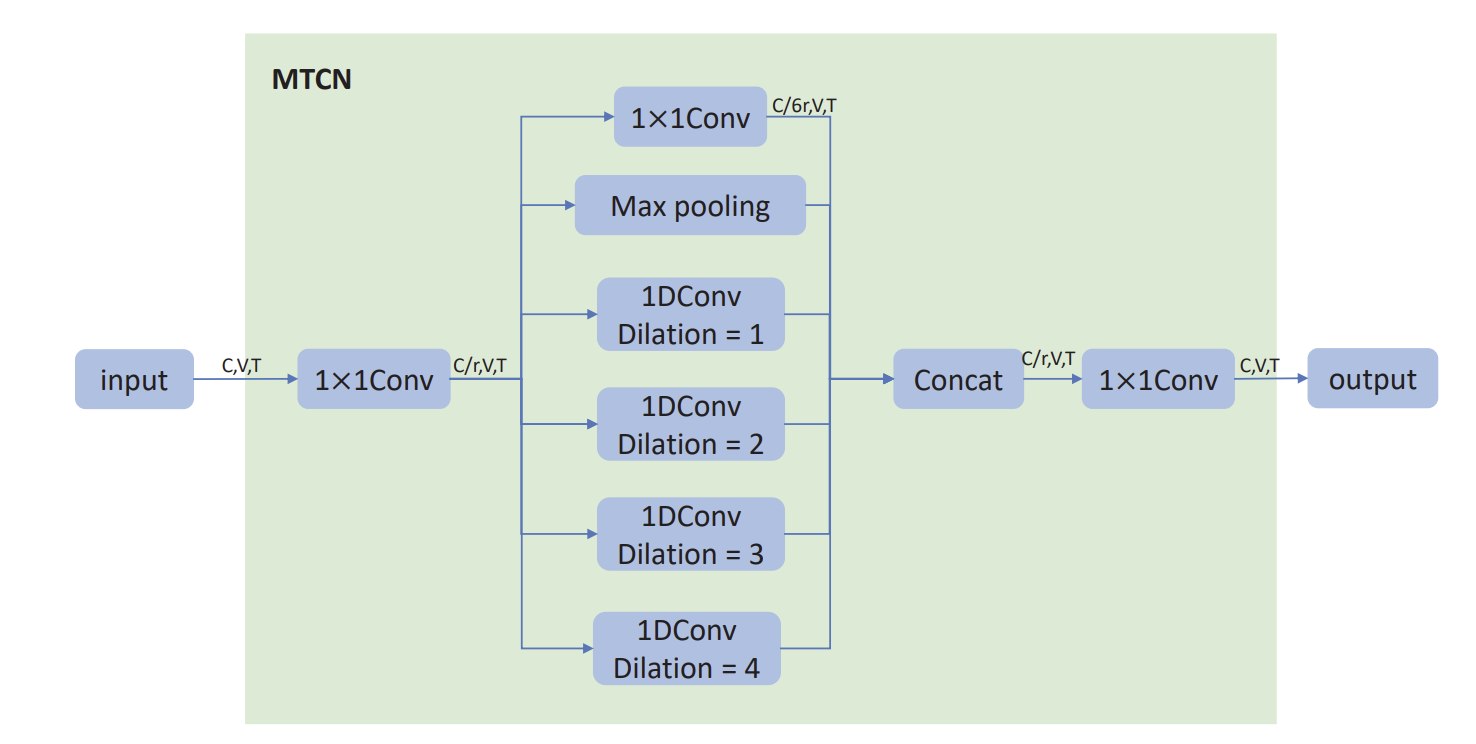

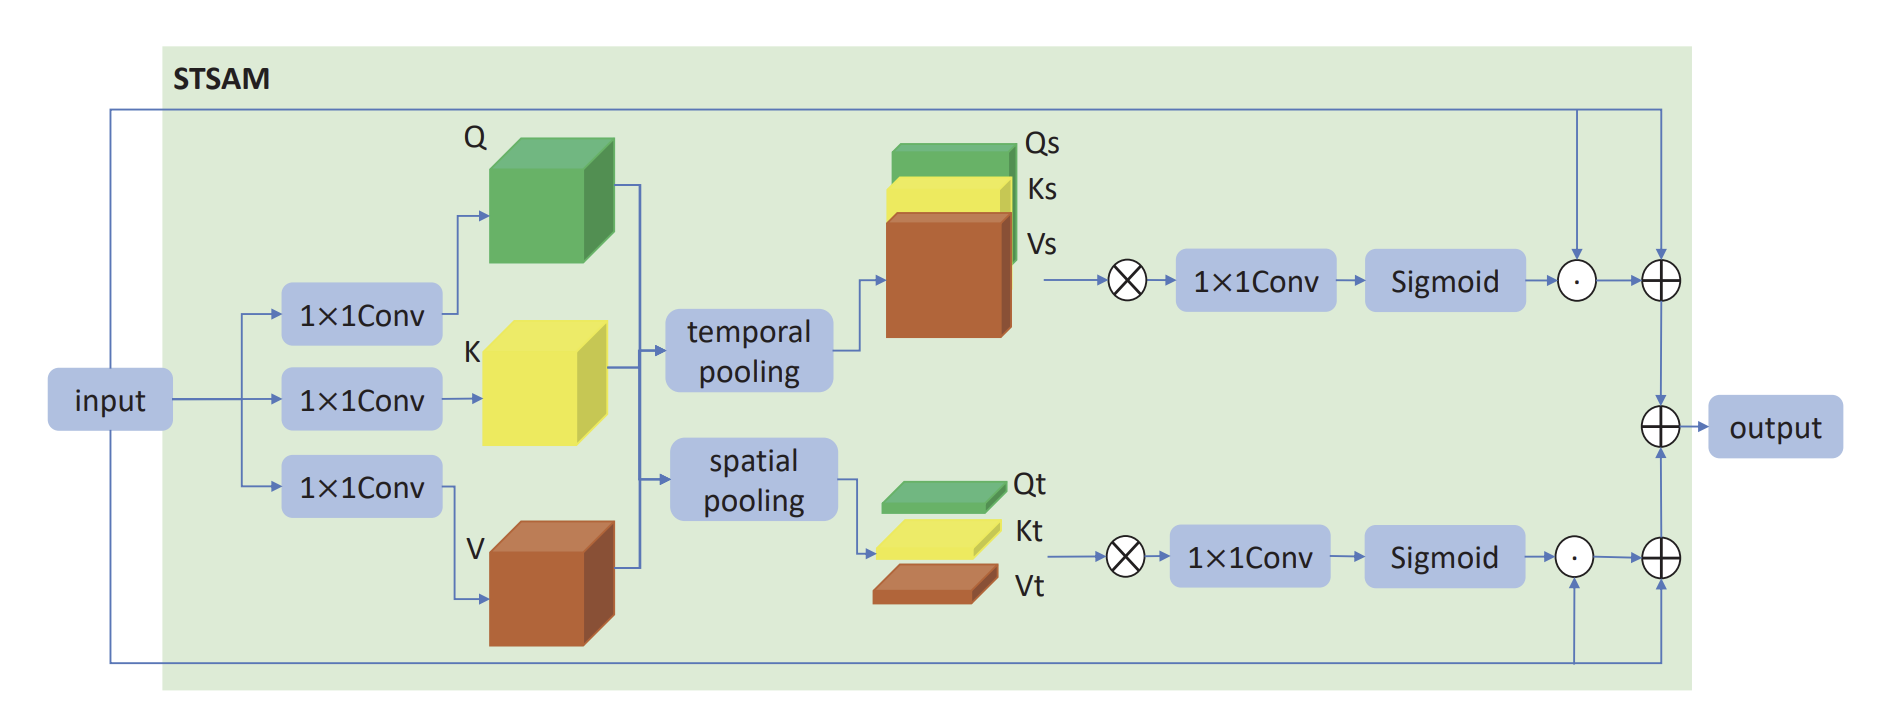

In [ ]:
class ST_SAE_GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ST_SAE_GCN, self).__init__()
        
        # Define layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.relu = torch.nn.ReLU()  # Activation function
        self.fc2 = torch.nn.Linear(hidden_size, output_size)  # Fully connected layer 2
    
    # Define the forward pass
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
from torchvision import transforms 
from PIL import Image


In [ ]:
# import torch

# Create an array of 5 tensors, each with shape (3, 3)
tensor_array = [torch.randn(3, 3) for _ in range(5)]
s = torch.stack([t for t in tensor_array], dim=2 )
s, tensor_array, s.shape

In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]])

In [ ]:
x.shape, x.view(-1).unsqueeze(0)

In [ ]:
import torch.nn as nn
softmax = nn.Softmax(dim=1)
softmax(x)
